# **Proyecto Individual de Detección de Objetvos**

Nombre: Michael Enrique Carreño Ramon

## Configuración inicial

In [1]:
# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Instalar dependencias
!pip install -q ultralytics

# 3. Importar librerías principales
import torch, os, glob, shutil, random, yaml, xml.etree.ElementTree as ET
from ultralytics import YOLO
print("YOLOv8 instalado correctamente")
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
YOLOv8 instalado correctamente
PyTorch: 2.8.0+cu126
CUDA disponible: True
GPU: Tesla T4


## Preparación del dataset

In [2]:
# 4. Definir rutas principales
DRIVE_ROOT     = "/content/drive/MyDrive"
IMAGES_DIR     = f"{DRIVE_ROOT}/PhawAI/DeepLearning/datacas/images"
ANNOTATIONS_DIR= f"{DRIVE_ROOT}/PhawAI/DeepLearning/datacas/annotations/"
YOLO_ROOT      = f"{DRIVE_ROOT}/PhawAI/DeepLearning/datacas/YOLODataset"

LABELS_ALL_DIR = f"{YOLO_ROOT}/labels_all"
os.makedirs(LABELS_ALL_DIR, exist_ok=True)

print("📂 IMAGES_DIR     :", IMAGES_DIR)
print("📂 ANNOTATIONS_DIR:", ANNOTATIONS_DIR)
print("📂 YOLO_ROOT      :", YOLO_ROOT)

📂 IMAGES_DIR     : /content/drive/MyDrive/PhawAI/DeepLearning/datacas/images
📂 ANNOTATIONS_DIR: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/annotations/
📂 YOLO_ROOT      : /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset


In [3]:
# 5. Verificar clases en los XML
unique_classes = set()
for xml_file in os.listdir(ANNOTATIONS_DIR):
    if xml_file.endswith(".xml"):
        root = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file)).getroot()
        for obj in root.findall("object"):
            unique_classes.add(obj.find("name").text.strip())
print("✅ Clases encontradas en XML:", unique_classes)

✅ Clases encontradas en XML: {'Without Helmet', 'With Helmet'}


In [4]:
# 6. Convertir anotaciones VOC a formato YOLO
CLASSES = ["helmet", "no_helmet"]

def voc_to_yolo(xml_file, classes):
    root = ET.parse(xml_file).getroot()
    w, h = int(root.find("size/width").text), int(root.find("size/height").text)
    lines = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.strip()
        if cls == "With Helmet": cls = "helmet"
        elif cls == "Without Helmet": cls = "no_helmet"
        else: continue
        cls_id = classes.index(cls)
        bb = obj.find("bndbox")
        xmin, ymin, xmax, ymax = map(float, [bb.find("xmin").text, bb.find("ymin").text, bb.find("xmax").text, bb.find("ymax").text])
        x_c, y_c, bw, bh = ((xmin+xmax)/2)/w, ((ymin+ymax)/2)/h, (xmax-xmin)/w, (ymax-ymin)/h
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")
    return lines

converted = 0
for xml_file in os.listdir(ANNOTATIONS_DIR):
    if xml_file.endswith(".xml"):
        lines = voc_to_yolo(os.path.join(ANNOTATIONS_DIR, xml_file), CLASSES)
        with open(os.path.join(LABELS_ALL_DIR, xml_file.replace(".xml",".txt")), "w") as f:
            f.write("\n".join(lines))
        converted += 1
print(f"✅ {converted} anotaciones convertidas a formato YOLO en {LABELS_ALL_DIR}")

✅ 764 anotaciones convertidas a formato YOLO en /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels_all


In [5]:
# 7. Verificar labels vacíos
label_files = glob.glob(f"{LABELS_ALL_DIR}/*.txt")
empty = sum(1 for lf in label_files if not open(lf).read().strip())
print(f"✅ Labels válidos: {len(label_files)-empty}")
print(f"⚠️ Labels vacíos: {empty}")

✅ Labels válidos: 761
⚠️ Labels vacíos: 3


In [6]:
# 8. Crear estructura de train/val/test
for split in ["train","val","test"]:
    shutil.rmtree(f"{YOLO_ROOT}/images/{split}", ignore_errors=True)
    shutil.rmtree(f"{YOLO_ROOT}/labels/{split}", ignore_errors=True)
    os.makedirs(f"{YOLO_ROOT}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_ROOT}/labels/{split}", exist_ok=True)

images = [p for ext in ("*.jpg","*.png") for p in glob.glob(os.path.join(IMAGES_DIR, ext))]
random.shuffle(images)

n = len(images)
splits = {
    "train": images[:int(0.7*n)],
    "val": images[int(0.7*n):int(0.9*n)],
    "test": images[int(0.9*n):]
}

def copy_pair(img_path, split):
    name = os.path.basename(img_path)
    shutil.copy(img_path, f"{YOLO_ROOT}/images/{split}/{name}")
    txt = os.path.join(LABELS_ALL_DIR, name.rsplit(".",1)[0]+".txt")
    shutil.copy(txt, f"{YOLO_ROOT}/labels/{split}/{os.path.basename(txt)}") if os.path.exists(txt) else open(f"{YOLO_ROOT}/labels/{split}/{os.path.basename(txt)}","w").close()

for split, file_list in splits.items():
    for img in file_list: copy_pair(img, split)

print("✅ Dataset organizado en train/val/test")

✅ Dataset organizado en train/val/test


In [7]:
# 9. Crear dataset.yaml
yaml_path = f"{YOLO_ROOT}/dataset.yaml"
with open(yaml_path, "w") as f:
    yaml.dump({
        "path": YOLO_ROOT,
        "train": "images/train",
        "val": "images/val",
        "test": "images/test",
        "names": {0:"helmet",1:"no_helmet"}
    }, f)
print("✅ dataset.yaml creado en:", yaml_path)
print(open(yaml_path).read())

✅ dataset.yaml creado en: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/dataset.yaml
names:
  0: helmet
  1: no_helmet
path: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset
test: images/test
train: images/train
val: images/val



## Entrenamiento de modelos

In [8]:
!pip install -U sympy
import sympy
print("Versión de sympy:", sympy.__version__)

Versión de sympy: 1.14.0


In [9]:
# 10. Entrenar variantes YOLOv8 (n, s, m)
yaml_path = f"{YOLO_ROOT}/dataset.yaml"
models = {"yolov8n":"yolov8n.pt", "yolov8s":"yolov8s.pt", "yolov8m":"yolov8m.pt"}

for name, weights in models.items():
    print(f"\n🚀 Entrenando {name}...\n")
    model = YOLO(weights)
    model.train(
        data=yaml_path,
        epochs=10, imgsz=640, batch=16,
        name=f"{name}_helmet",
        project="/content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results", # guardado en Drive
    )


🚀 Entrenando yolov8n...

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_helmet3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

train: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/train... 534 images, 2 backgrounds, 11 corrupt: 100%|██████████| 534/534 [00:05<00:00, 94.73it/s] 

train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     682.27       150.5      118.22         107]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      310.5        41.5          61          63]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/Bikes

train: New cache created: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.1±4.6 ms, read: 137.2±97.3 MB/s, size: 609.1 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:02<00:00, 75.63it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]


val: New cache created: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache
Plotting labels to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         2G      1.576      3.405      1.326         15        640: 100%|██████████| 33/33 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        150        281    0.00584      0.933      0.243      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.49G      1.449      2.217       1.22         20        640: 100%|██████████| 33/33 [00:14<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        150        281      0.887     0.0345      0.178     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.51G      1.432      2.001      1.216         19        640: 100%|██████████| 33/33 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        150        281      0.735      0.431      0.533      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.51G      1.401      1.834        1.2         20        640: 100%|██████████| 33/33 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

                   all        150        281      0.585      0.672      0.636      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.51G      1.355       1.63      1.187         22        640: 100%|██████████| 33/33 [00:14<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        150        281      0.701      0.647      0.687      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.51G      1.364      1.491      1.184         24        640: 100%|██████████| 33/33 [00:14<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        150        281      0.691      0.773      0.729      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.51G      1.304      1.357      1.149         19        640: 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        150        281      0.598      0.739      0.741      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.51G      1.296      1.268      1.132         27        640: 100%|██████████| 33/33 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        150        281      0.681      0.753      0.734      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.51G      1.269      1.221      1.139         24        640: 100%|██████████| 33/33 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        150        281      0.673      0.843      0.769      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.51G      1.239       1.16      1.104         18        640: 100%|██████████| 33/33 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        150        281      0.724      0.869      0.815      0.494



10 epochs completed in 0.051 hours.
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


                   all        150        281      0.724      0.869      0.814      0.495
                helmet        114        203      0.777      0.906      0.864      0.548
             no_helmet         41         78       0.67      0.832      0.765      0.443
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3

🚀 Entrenando yolov8s...



Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_helmet, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

train: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/train.cache... 534 images, 2 backgrounds, 11 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     682.27       150.5      118.22         107]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      310.5        41.5          61          63]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/Bikes

val: Fast image access ✅ (ping: 10.6±21.7 ms, read: 47.6±49.4 MB/s, size: 609.1 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]


Plotting labels to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.78G       1.65      4.135      1.405         15        640: 100%|██████████| 33/33 [00:17<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        150        281      0.481      0.642      0.497      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.76G      1.474      1.506      1.266         20        640: 100%|██████████| 33/33 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        150        281       0.16      0.562      0.152     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.76G      1.453      1.295      1.244         19        640: 100%|██████████| 33/33 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        150        281      0.441      0.727      0.551      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.76G      1.415      1.239      1.223         20        640: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        150        281      0.463      0.654      0.591      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.76G      1.398      1.156      1.237         22        640: 100%|██████████| 33/33 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        150        281      0.598      0.688      0.672      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.76G      1.393      1.068      1.212         24        640: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        281        0.7      0.693      0.715      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.76G       1.34     0.9494        1.2         19        640: 100%|██████████| 33/33 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        281      0.683      0.767      0.756      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.76G        1.3     0.8986      1.183         27        640: 100%|██████████| 33/33 [00:17<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        150        281      0.695      0.847      0.807      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.76G      1.281     0.8511      1.171         24        640: 100%|██████████| 33/33 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        150        281      0.726      0.835      0.787      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.76G      1.249     0.7941      1.139         18        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        150        281      0.726      0.819      0.795      0.497



10 epochs completed in 0.060 hours.
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


                   all        150        281      0.708      0.854      0.795      0.497
                helmet        114        203      0.756      0.887      0.875      0.573
             no_helmet         41         78      0.659      0.821      0.715       0.42
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet

🚀 Entrenando yolov8m...



Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_helmet, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

train: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/train.cache... 534 images, 2 backgrounds, 11 corrupt: 100%|██████████| 534/534 [00:00<?, ?it/s]

train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     682.27       150.5      118.22         107]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      310.5        41.5          61          63]
train: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/train/Bikes

val: Fast image access ✅ (ping: 2.8±3.1 ms, read: 133.3±78.0 MB/s, size: 609.1 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]


Plotting labels to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.54G      1.684      4.446      1.491         15        640: 100%|██████████| 33/33 [00:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        150        281      0.381      0.467      0.347      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.54G      1.543      1.742      1.369         20        640: 100%|██████████| 33/33 [00:18<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        150        281    0.00238       0.22    0.00154    0.00078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.53G      1.468      1.515      1.321         19        640: 100%|██████████| 33/33 [00:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        150        281    0.00201     0.0517   0.000961   0.000367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.61G      1.476      1.383      1.314         20        640: 100%|██████████| 33/33 [00:21<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        150        281      0.308      0.548      0.421      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.54G       1.45      1.313      1.304         22        640: 100%|██████████| 33/33 [00:24<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        150        281      0.392      0.705      0.643      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.61G      1.418      1.244      1.297         24        640: 100%|██████████| 33/33 [00:24<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        150        281      0.487      0.697      0.681      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.63G      1.356      1.089      1.237         19        640: 100%|██████████| 33/33 [00:24<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        150        281      0.651      0.785      0.783      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.62G      1.305     0.9803      1.219         27        640: 100%|██████████| 33/33 [00:25<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        150        281       0.75       0.82      0.816      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.53G      1.308     0.9367       1.23         24        640: 100%|██████████| 33/33 [00:24<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        150        281      0.717      0.856      0.805      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       6.6G      1.275     0.8923      1.192         18        640: 100%|██████████| 33/33 [00:24<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        150        281      0.753      0.829      0.803      0.504



10 epochs completed in 0.078 hours.
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all        150        281      0.758      0.829      0.804      0.506
                helmet        114        203       0.78      0.838      0.869      0.574
             no_helmet         41         78      0.735      0.821       0.74      0.439
Speed: 0.3ms preprocess, 9.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet


## Evaluación

In [14]:
# 11. Evaluar cada modelo en validación
import os

models_paths = [
    "/content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/weights/best.pt",
    "/content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/weights/best.pt",
    "/content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/weights/best.pt"
]

for path in models_paths:
    print(f"{'✅' if os.path.exists(path) else '❌'} {path}")


✅ /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8n_helmet3/weights/best.pt
✅ /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8s_helmet/weights/best.pt
✅ /content/drive/MyDrive/PhawAI/DeepLearning/YOLO_results/yolov8m_helmet/weights/best.pt


## Visualización de resultados

In [11]:
# 12. Mostrar gráficas de entrenamiento
import matplotlib.pyplot as plt
from IPython.display import Image, display

for name in models.keys():
    run_dir = f"/content/drive/MyDrive/PhawAI/YOLO_results/{name}_helmet"
    for img in ["results.png","confusion_matrix.png","F1_curve.png","PR_curve.png"]:
        path = f"{run_dir}/{img}"
        if os.path.exists(path):
            display(Image(filename=path))

In [12]:
# 13. Inferencia en imágenes de test
test_images = glob.glob(f"{YOLO_ROOT}/images/test/*.png")[:5]
for name in models.keys():
    best_model = f"/content/drive/MyDrive/PhawAI/YOLO_results/{name}_helmet/weights/best.pt"
    if os.path.exists(best_model):
        model = YOLO(best_model)
        results = model.predict(source=test_images, save=True, imgsz=640, conf=0.25)
        print(f"\n🔎 Ejemplos con {name}")
        for r in results:
            display(Image(filename=r.path))

In [15]:
import pandas as pd

# Diccionario para guardar métricas
results_summary = {}

# Evaluar cada modelo
for name, path in zip(
    ["yolov8n","yolov8s","yolov8m"], models_paths
):
    if os.path.exists(path):
        model = YOLO(path)
        metrics = model.val()
        results_summary[name] = {
            "Precision": metrics.box.mp,   # precisión media
            "Recall": metrics.box.mr,      # recall medio
            "mAP@0.5": metrics.box.map50,  # mAP IoU=0.5
            "mAP@0.5:0.95": metrics.box.map  # mAP en múltiple IoU
        }

# Convertir a DataFrame
df_results = pd.DataFrame(results_summary).T
print(df_results)

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 5.8±12.1 ms, read: 132.9±85.3 MB/s, size: 481.3 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


                   all        150        281      0.745      0.861      0.812      0.496
                helmet        114        203      0.787      0.901      0.865      0.548
             no_helmet         41         78      0.702      0.821      0.759      0.444
Speed: 8.8ms preprocess, 11.4ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs/detect/val
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 159.7±78.1 MB/s, size: 420.2 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        150        281      0.727      0.833      0.794      0.494
                helmet        114        203      0.778      0.867      0.875      0.572
             no_helmet         41         78      0.675        0.8      0.712      0.416
Speed: 4.2ms preprocess, 8.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val2
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 218.1±45.8 MB/s, size: 594.2 KB)


val: Scanning /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/labels/val.cache... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/drive/MyDrive/PhawAI/DeepLearning/datacas/YOLODataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


                   all        150        281      0.745      0.804        0.8      0.505
                helmet        114        203       0.78      0.823      0.866      0.571
             no_helmet         41         78       0.71      0.786      0.734       0.44
Speed: 2.6ms preprocess, 16.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val3
         Precision    Recall   mAP@0.5  mAP@0.5:0.95
yolov8n   0.744610  0.860995  0.811907      0.495586
yolov8s   0.726720  0.833411  0.793531      0.494145
yolov8m   0.745358  0.804383  0.799880      0.505141



🔎 Detecciones con yolov8n

0: 640x640 3 no_helmets, 5.6ms
1: 640x640 2 helmets, 5.6ms
2: 640x640 2 no_helmets, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


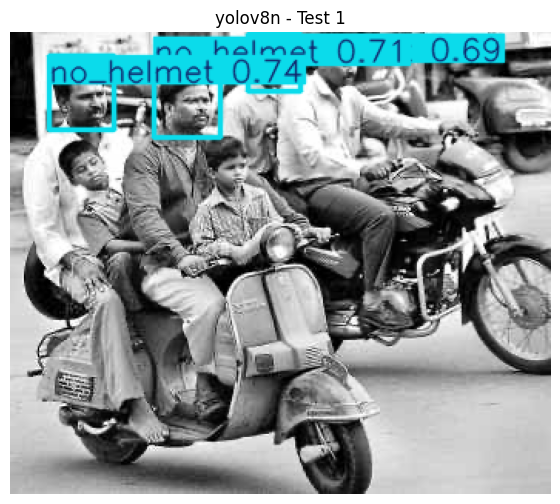

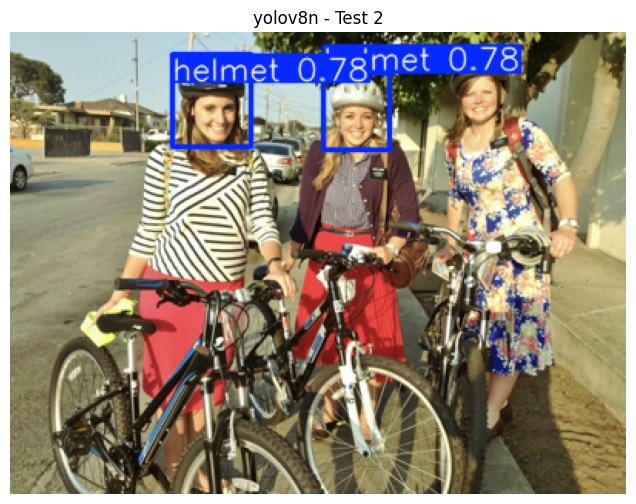

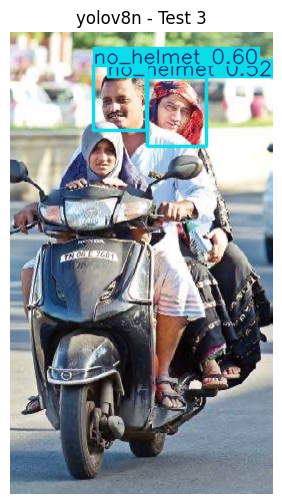


🔎 Detecciones con yolov8s

0: 640x640 5 no_helmets, 13.6ms
1: 640x640 3 helmets, 13.6ms
2: 640x640 3 no_helmets, 13.6ms
Speed: 3.5ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


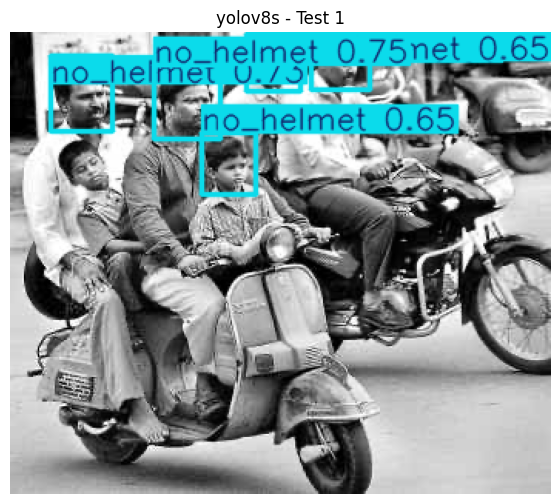

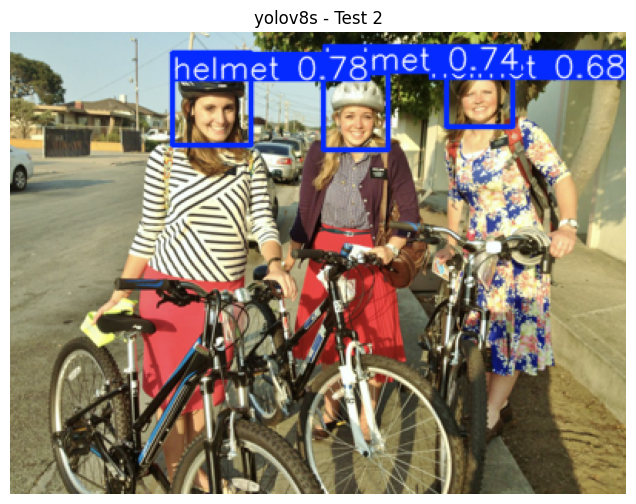

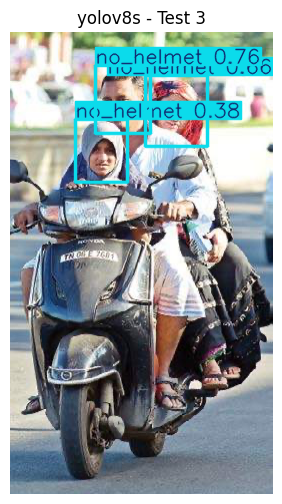


🔎 Detecciones con yolov8m

0: 640x640 5 no_helmets, 31.0ms
1: 640x640 3 helmets, 31.0ms
2: 640x640 3 no_helmets, 31.0ms
Speed: 2.9ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


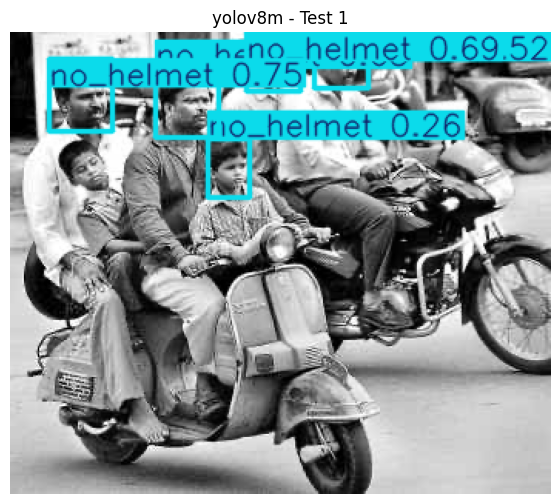

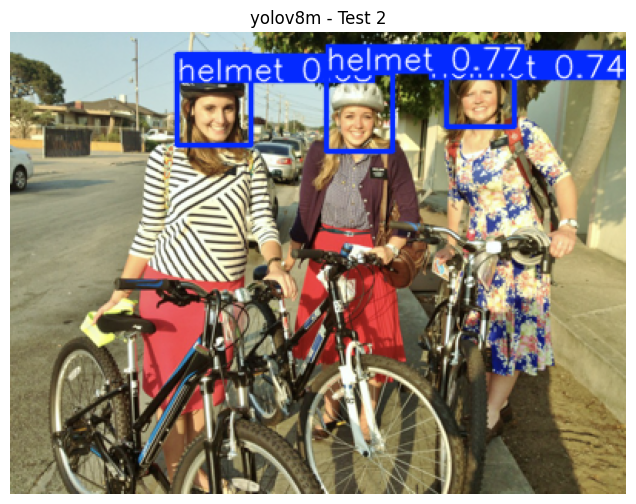

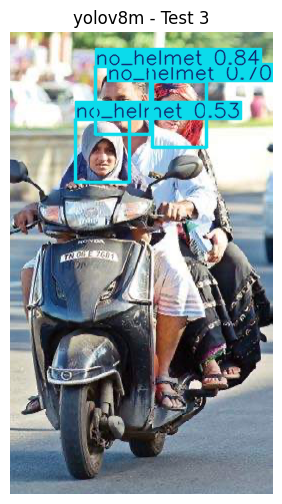

In [17]:
import cv2
import matplotlib.pyplot as plt

# Inferencia en imágenes de test con los 3 modelos
test_images = glob.glob(f"{YOLO_ROOT}/images/test/*.png")[:3]  # usa 3 imágenes de test

for name, path in zip(
    ["yolov8n","yolov8s","yolov8m"], models_paths
):
    if os.path.exists(path):
        print(f"\n🔎 Detecciones con {name}")
        model = YOLO(path)
        results = model(test_images, conf=0.25)  # predicciones sin guardar en disco

        # Iterar cada resultado de imagen
        for i, r in enumerate(results):
            # Dibujar las cajas en la imagen
            img = r.plot()  # plot() ya incluye bounding boxes, etiquetas y score
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Mostrar
            plt.figure(figsize=(8,6))
            plt.imshow(img_rgb)
            plt.axis("off")
            plt.title(f"{name} - Test {i+1}")
            plt.show()